In [1]:
import geopandas as gpd
import pandas as pd
import fiona
import numpy as np
from PIL import Image
#import pysal as ps
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from scipy import stats
from scipy.optimize import curve_fit
import seaborn as sns

In [2]:
import gdal

In [3]:
def density_calc(city):
    city['area'] = city.area
    epsilon = 1e-1
    city['urbandensity'] = city.Urban_Tiles / city.area#np.log10(epsilon + city.Urban_Tiles / city.area)
    city['urbandensity_norm'] = (city['urbandensity'] - city['urbandensity'].min())/(city['urbandensity'].max() - city['urbandensity'].min())
    #city['urbandensity'] = city['Urban_Tiles'] / city['area']

In [4]:
def df_convex_calc(city):
    city_convex = city.convex_hull
    city['area'] = city.area
    city['area_convex'] = city_convex.area
    city['length'] = city.length
    city['length_convex'] = city_convex.length
    city['area_ratio'] = city['area'] / city['area_convex']
    city['perimeter_ratio'] = city['length'] / city['length_convex']

In [5]:
#DataFrame Initialization for Metro Manila
metro_manila = gpd.read_file("metro_manila/metro_manila.shp")
urban_manila = pd.read_csv("Statistics/MetroManila2010.csv")

#DataFrame Initialization for Quezon City
quezon_city = gpd.read_file("quezon_city/quezon_city.shp")
urban_qc = pd.read_csv("Statistics/QuezonCity2010.csv")
temp_qc = pd.read_csv("Statistics/Quezon City Jan 2010 8 Day Temp.csv")

#DataFrame Initialization for Davao City
davao_city = gpd.read_file("davao_city/davao_city.shp")
urban_davao = pd.read_csv("Statistics/Davao2010.csv")

#DataFrame Initialization for NCR without Manila City
ncr = gpd.read_file("ncr_without_mnl/ncr_without_mnl.shp")
urban_ncr = pd.read_csv("Statistics/NCR_working.csv")

#DataFrame Initialization for Metro Manila using PhilGIS
dfpg = gpd.read_file("metro_manila_philgis/Metropolitan Manila.shp")

#pd.options.display.float_format = '{:,.0f}'.format
df = quezon_city
urban = urban_qc
temp = temp_qc
urban.fillna(0, inplace = True)
#urban.iloc[len(urban)-1,11] = 0.0

In [6]:
urban2010 = urban[urban.Date == "2010-01-01"].reset_index()

In [7]:
df.insert(9, 'Urban_Tiles', urban2010['(13) Urban and Built-up Lands'])

In [8]:
for index, row in df.iterrows():
    neighbors = df[df.geometry.touches(row['geometry']) & df['Urban_Tiles'] != 0].NAME_3.tolist() 
    #neighbors = neighbors.remove(row.NAME_3)
    df.at[index, "neighbors"] = ", ".join(neighbors)

In [9]:
#pd.options.display.max_rows = 150
#df.plot(column = 'Urban_Tiles', figsize = [12,12], legend = True, cmap = "OrRd")
#df[df['Urban_Tiles'] <3].plot(figsize = [12,12])

In [10]:
df_transform = df.to_crs(epsg=4326) #Transforms CRS to PRS92 (EPSG:3124)
#http://spatialreference.org/ref/epsg/3123/ , https://epsg.io/25391
density_calc(df)
density_calc(df_transform)

## Urban Density plots of different CRS

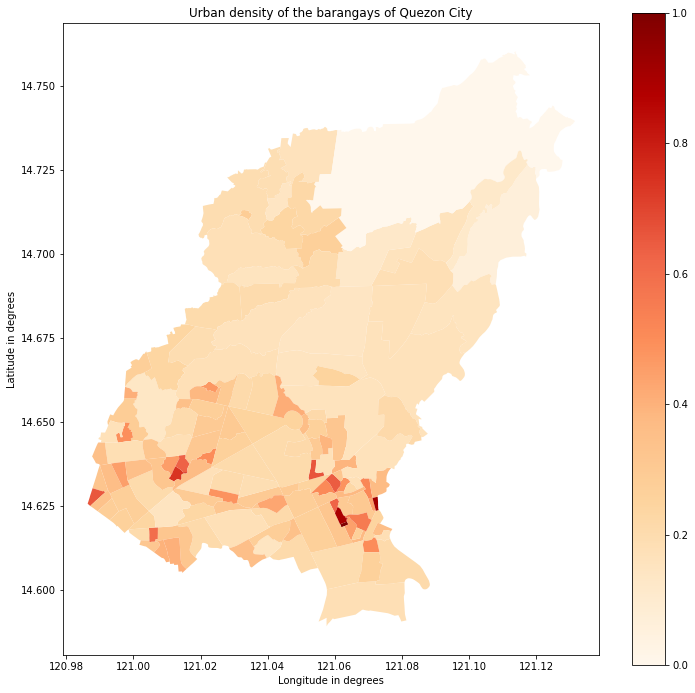

In [11]:
df.plot(column = 'urbandensity_norm',cmap = "OrRd",figsize = [12,12], legend = True)#.sort_values('Urban_Tiles', ascending = False)
plt.xlabel("Longitude in degrees")
plt.ylabel("Latitude in degrees")
plt.title("Urban density of the barangays of Quezon City")
plt.savefig("qc_density", dpi = 600, bbox_inches = 'tight')

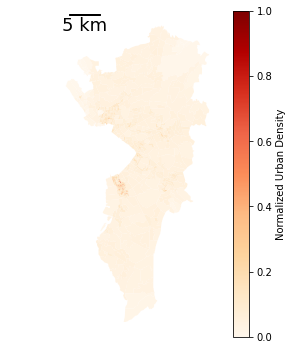

In [11]:
fontprops = fm.FontProperties(size=18)
fig, ax = plt.subplots(figsize = [6,6])
df_transform.plot(ax = ax, column = 'urbandensity_norm',cmap = "OrRd",figsize = [12,12], legend = True)#.sort_values('Urban_Tiles', ascending = False)
ax.axis("off")
fig.get_children()[2].set_ylabel("Normalized Urban Density")
scalebar = AnchoredSizeBar(ax.transData,
                           5000, '5 km', 'upper left', 
                           pad=0.1,
                           color='black',
                           frameon=False,
                           size_vertical=100,
                           fontproperties=fontprops)

ax.add_artist(scalebar)
# plt.xlabel("Longitude in meters")
# plt.ylabel("Latitude in meters")
#plt.title("Urban density of the barangays of Quezon City")
plt.savefig("qc_density", dpi = 600, bbox_inches = 'tight')

## Scatter plot of Urban Density vs Area and Perimeter ratios

In [12]:
df_convex_calc(df)
df_convex_calc(df_transform)

### Non-transformed GeoDataFrame

In [13]:
axis_font = {'fontname':'Arial', 'size':'16'}
inset_font = {'fontname':'Arial', 'size':'9'}

In [16]:
x = df['area_ratio']
x_per = df['perimeter_ratio']
y = df['urbandensity_norm']
points = pd.DataFrame({'area_ratio':x, 'perimeter_ratio': x_per, 'urbandensity_norm':y})
tick_range = np.linspace(points['area_ratio'].min(), points['area_ratio'].max(), 15)
tick_range_per = np.linspace(points['perimeter_ratio'].min(), points['perimeter_ratio'].max(), 16)
mid_points = np.zeros(len(tick_range)-1)
mid_per = np.zeros(len(tick_range_per)-1)
max_points = np.zeros(len(mid_points))
max_points_per = np.zeros(len(mid_per))
for i in range(0,len(mid_points)):
    #mid_points[i] = (tick_range[i]+tick_range[i+1]) / 2
    ran = points[(points["area_ratio"] >= tick_range[i]) & (points["area_ratio"] <= tick_range[i+1])]
    max_points[i] = ran["urbandensity_norm"].max()
    mid_point = ran[ran["urbandensity_norm"] == max_points[i]]
    #display(mid_point)
    #print(mid_point.iloc[0,0])
    mid_points[i] = mid_point.iloc[0,0]
    
for i in range(0,len(mid_per)):
    #mid_per[i] = (tick_range_per[i]+tick_range_per[i+1]) / 2
    ran = points[(points["perimeter_ratio"] >= tick_range_per[i]) & (points["perimeter_ratio"] <= tick_range_per[i+1])]
    max_points_per[i] = ran["urbandensity_norm"].max()
    mid_pers = ran[ran["urbandensity_norm"] == max_points_per[i]]
    #display(mid_pers)
    #print(max_points_per[i], mid_pers.iloc[0,1])
    mid_per[i] = mid_pers.iloc[0,1]

0.3177324171001299
0.3799878933950657
0.4430523927609818
0.46422957009904975
0.5418770600249146
0.6029336986117427
0.6210820840114288
0.6772867786075064
0.7439923677339187
0.7868355150561285
0.8395843992418257
0.8776284485412028
0.9434175439632625
0.9964656165513279
1.0 1.0000470452891226
0.4559485304382741 1.0364581729057503
0.3244476071007833 1.112041046622505
0.22366572048818076 1.1826359234093193
0.27472594722990445 1.1957219701960737
0.22443842803517905 1.2536989437475796
0.10549832551112641 1.3141098261545605
0.05874370387499862 1.3636182062900506
0.0484040960965394 1.4132108576955837
0.05998997948808923 1.4697115297021772
0.06037830262511622 1.5412682462123537
0.06751120936028954 1.548243839493154
0.05854380830355897 1.6006964319433432
0.04417318866871207 1.6705275884617887
0.07024994807505242 1.7519403040436075


slope: 0.884393    intercept: -0.251639
r-squared: 0.597268


/usr/local/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


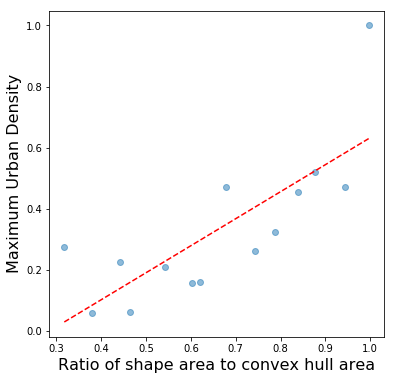

In [17]:
slope, intercept, r_value, p_value, std_err = stats.linregress(mid_points, max_points)

plt.figure(figsize=[6,6])
plt.plot(mid_points, max_points, '.', markersize = 12, alpha = 0.5, label = 'original data')
print("slope: %f    intercept: %f" % (slope, intercept))
print("r-squared: %f" % r_value**2)
#plt.plot(x, y, '.', markersize = 12, alpha = 0.5, label = 'original data')
plt.plot(mid_points, intercept + slope*mid_points, 'r--', label='fitted line')
#plt.legend()
plt.xlabel("Ratio of shape area to convex hull area", **axis_font)
plt.ylabel("Maximum Urban Density", **axis_font)
plt.savefig("Area", dpi = 600, bbox_inches = 'tight')

#draw y=x line

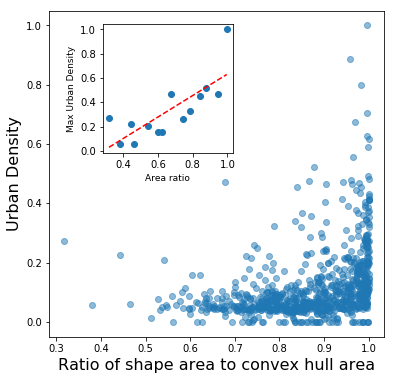

In [32]:
fig, ax1 = plt.subplots(figsize = [6,6])
# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.25, 0.55, 0.3, 0.3]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(x, y, '.', markersize = 12, alpha = 0.5, label = 'original data')
ax1.set_xlabel("Ratio of shape area to convex hull area", **axis_font)
ax1.set_ylabel("Urban Density", **axis_font)
ax2.plot(mid_points, max_points, '.', markersize = 12, label = 'original data')
ax2.plot(mid_points, intercept + slope*mid_points, 'r--', label='fitted line')
ax2.set_xlabel("Area ratio", **inset_font)
ax2.set_ylabel("Max Urban Density", **inset_font)
plt.savefig("Area_inset", dpi = 600, bbox_inches = 'tight')
plt.show()

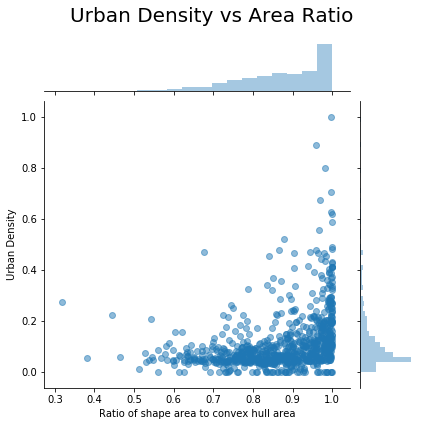

In [57]:
g = sns.jointplot(x=x, y=y, alpha = 0.5).set_axis_labels("Ratio of shape area to convex hull area", "Urban Density")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Urban Density vs Area Ratio', fontsize = 20)
plt.savefig("area_marginal.png")

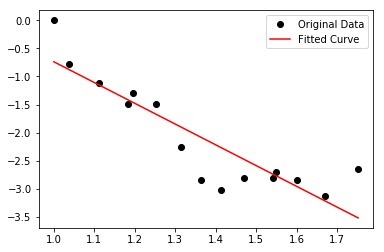

[ 2.95749771 -3.6960374 ]
0.7882393935403732


In [35]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(mid_per, max_points_per)
def func(x,a,b):
    return (b*x)+a

#func_x = np.linspace(mid_per[0],mid_per[len(mid_per-1)])
#func_y = func(func_x,)

#popt, pcov = curve_fit(func,np.log(mid_per),np.log(max_points_per))
popt, pcov = curve_fit(func,mid_per,np.log(max_points_per))
slope, intercept, r_value, p_value, std_err = stats.linregress(mid_per, np.log(max_points_per))
plt.figure()
plt.plot(mid_per, np.log(max_points_per), 'ko', label="Original Data")
plt.plot(mid_per, func(mid_per, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()
print(popt)
print(r_value**2)

In [36]:
ran = len(mid_per)//2-2
slope, intercept, r_value, p_value, std_err = stats.linregress(mid_per[0:ran], max_points_per[0:ran])
slope2, intercept2, r_value2, p_value2, std_err2 = stats.linregress(mid_per[ran-1:], max_points_per[ran-1:])
#line1 = np.polyfit(mid_per[0:len(mid_per)//2], max_points_per[0:len(max_points_per)//2], 1)
#line2 = np.polyfit(mid_per[len(mid_per)//2:], max_points_per[len(max_points_per)//2:], 1)

# y1 = intercept + slope*mid_per[0:ran]
# y2 = intercept2 + slope2*mid_per[ran:]
# y_con = np.concatenate([y1,y2])

y_con = np.exp(2.957)*np.exp(mid_per*-3.696)

#print(slope, intercept, r_value**2)
#print(slope2, intercept2, r_value2**2)
#draw y=x line

In [37]:
np.exp(2.957)

19.240164594333365

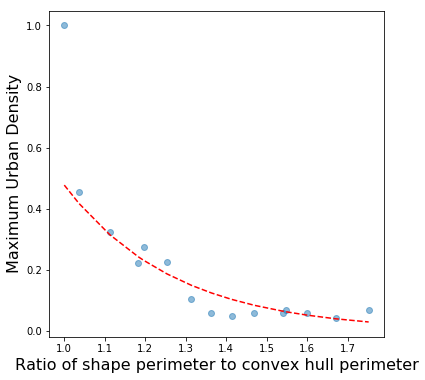

In [38]:
plt.figure(figsize=[6,6])
plt.plot(mid_per, max_points_per, '.', markersize = 12, alpha = 0.5, label = 'original data')
#print("slope: %f    intercept: %f" % (slope, intercept))
#print("r-squared: %f" % r_value**2)
#plt.plot(x, y, '.', markersize = 12, alpha = 0.5, label = 'original data')
plt.plot(mid_per, y_con, 'r--', label='fitted line')
#plt.legend()
plt.xlabel("Ratio of shape perimeter to convex hull perimeter", **axis_font)
plt.ylabel("Maximum Urban Density", **axis_font)
plt.savefig("Perimeter", dpi = 600, bbox_inches = 'tight')

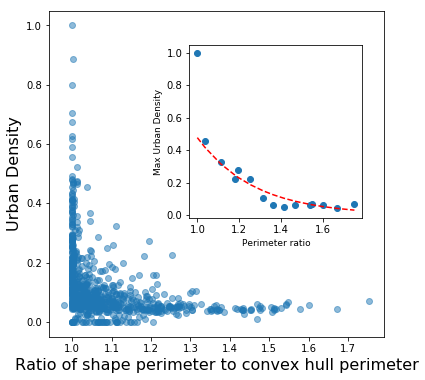

In [39]:
#slope, intercept, r_value, p_value, std_err = stats.linregress(mid_per, max_points_per)

fig, ax1 = plt.subplots(figsize = [6,6])

# These are in unitless percentages of the figure size. (0,0 is bottom left)
left, bottom, width, height = [0.45, 0.4, 0.4, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])

ax1.plot(x_per, y, '.', markersize = 12, alpha = 0.5, label = 'original data')
ax1.set_xlabel("Ratio of shape perimeter to convex hull perimeter", **axis_font)
ax1.set_ylabel("Urban Density", **axis_font)
ax2.plot(mid_per, max_points_per, '.', markersize = 12, label = 'original data')
ax2.plot(mid_per, y_con, 'r--', label='fitted line')
ax2.set_xlabel("Perimeter ratio", **inset_font)
ax2.set_ylabel("Max Urban Density", **inset_font)
plt.savefig("Perimeter_inset", dpi = 600, bbox_inches = 'tight')
plt.show()

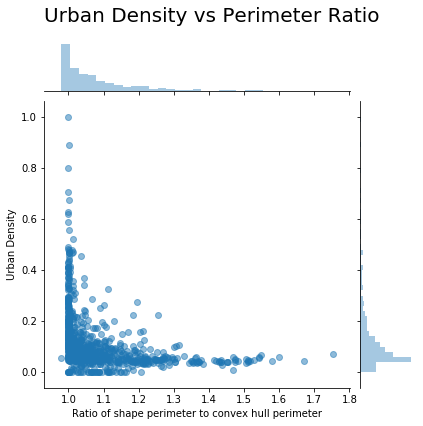

In [58]:
g = sns.jointplot(x=x_per, y=y, alpha = 0.5).set_axis_labels("Ratio of shape perimeter to convex hull perimeter", "Urban Density")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Urban Density vs Perimeter Ratio', fontsize = 20)
plt.savefig("perimeter_marginal.png")

slope: 0.349805    intercept: -0.184583
r-squared: 0.120497


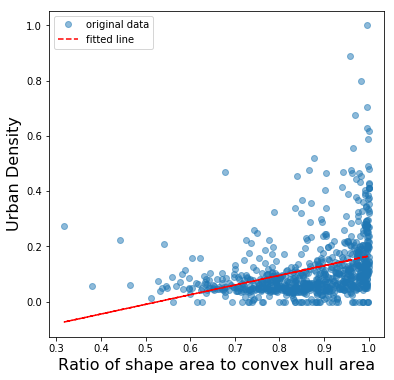

In [115]:
axis_font = {'fontname':'Arial', 'size':'16'}

x = df['area_ratio']
y = df['urbandensity_norm']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r-squared: %f" % r_value**2)
#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)

plt.figure(figsize=[6,6])
# plt.scatter(x, y, alpha = 0.5)
# plt.plot(x,p(x),"r--")
plt.plot(x, y, '.', markersize = 12, alpha = 0.5, label = 'original data')
plt.plot(x, intercept + slope*x, 'r--', label='fitted line')
plt.legend()
plt.xlabel("Ratio of shape area to convex hull area", **axis_font)
plt.ylabel("Urban Density", **axis_font)
plt.savefig("Area", dpi = 600, bbox_inches = 'tight')
plt.show()
#draw y=x line

slope: -0.343014    intercept: 0.492359
r-squared: 0.122003


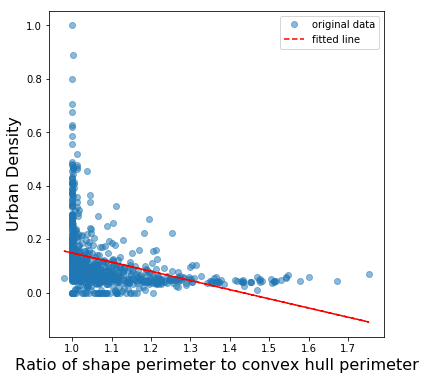

In [79]:
x = df['perimeter_ratio']
y = df['urbandensity_norm']
slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
print("slope: %f    intercept: %f" % (slope, intercept))
print("r-squared: %f" % r_value**2)
#z = np.polyfit(x, y, 1)
#p = np.poly1d(z)

plt.figure(figsize=[6,6])
# plt.scatter(x, y, alpha = 0.5)
# plt.plot(x,p(x),"r--")
plt.plot(x, y, '.', markersize = 12, alpha = 0.5, label = 'original data')
plt.plot(x, intercept + slope*x, 'r--', label='fitted line')
plt.legend()
plt.xlabel("Ratio of shape perimeter to convex hull perimeter", **axis_font)
plt.ylabel("Urban Density", **axis_font)
plt.savefig("Area", dpi = 600, bbox_inches = 'tight')
plt.show()
#draw y=x line

In [95]:
df.sort_values(by = ['urbandensity_norm'], ascending = True).head(3)

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,Urban_Tiles,...,geometry,neighbors,area,urbandensity,urbandensity_norm,area_convex,length,length_convex,area_ratio,perimeter_ratio
792,177,PHL,Philippines,47,Metropolitan Manila,966,Valenzuela,25832,Wawang Pulo,0.0,...,"POLYGON ((120.9354629516603 14.73050022125256,...",,0.000029,0.0,0.0,0.000034,0.026339,0.022761,0.834572,1.157173
770,177,PHL,Philippines,47,Metropolitan Manila,966,Valenzuela,25810,Isla,0.0,...,"POLYGON ((120.9517059326172 14.71263027191168,...",Pasolo,0.000008,0.0,0.0,0.000010,0.013658,0.012759,0.808676,1.070489
45,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24187,Barangay 14,0.0,...,"POLYGON ((120.9663009643557 14.6522302627564, ...",n.a.,0.000001,0.0,0.0,0.000001,0.004995,0.004826,0.917462,1.034879


In [89]:
df_transform.sort_values(by = ['area'], ascending = True).head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,Urban_Tiles,...,geometry,neighbors,area,urbandensity,urbandensity_norm,area_convex,length,length_convex,area_ratio,perimeter_ratio
487,177,PHL,Philippines,47,Metropolitan Manila,960,Pasay City,25527,Barangay 50,1.0,...,"POLYGON ((284112.0085273107 1610866.64132662, ...","Barangay 46, Barangay 47, Barangay 48, Baranga...",5068.705814,0.000197,1.000000,5086.683776,287.220172,287.207113,0.996466,1.000045
501,177,PHL,Philippines,47,Metropolitan Manila,960,Pasay City,25541,Barangay 63,1.0,...,"POLYGON ((284438.63869037 1610402.067465239, 2...","Barangay 60, Barangay 61, Barangay 62, Baranga...",5706.200329,0.000175,0.888280,5956.036131,372.880935,372.138387,0.958053,1.001995
493,177,PHL,Philippines,47,Metropolitan Manila,960,Pasay City,25533,Barangay 56,1.0,...,"POLYGON ((284149.7614519972 1610576.282496331,...","Barangay 52, Barangay 53, Barangay 54, Baranga...",6345.187242,0.000158,0.798827,6455.664254,327.259570,327.182970,0.982887,1.000234
359,177,PHL,Philippines,47,Metropolitan Manila,960,Pasay City,25399,Barangay 116,1.0,...,"POLYGON ((284648.4826264922 1609378.535658472,...","Barangay 113, Barangay 115, Barangay 117, Bara...",7191.483389,0.000139,0.704821,7212.111062,340.749814,340.738180,0.997140,1.000034
522,177,PHL,Philippines,47,Metropolitan Manila,960,Pasay City,25562,Barangay 82,1.0,...,"POLYGON ((284135.8326490269 1609368.474060248,...","Barangay 80, Barangay 81, Barangay 83, Baranga...",7511.347338,0.000133,0.674806,7744.509302,423.384976,423.256414,0.969893,1.000304


In [97]:
df[df["Urban_Tiles"] == 0]

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,ID_3,NAME_3,Urban_Tiles,...,geometry,neighbors,area,urbandensity,urbandensity_norm,area_convex,length,length_convex,area_ratio,perimeter_ratio
1,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24143,Barangay 10,0.0,...,"POLYGON ((120.9677658081055 14.65594100952154,...",Barangay 8,0.000003,0.0,0.0,0.000004,0.009529,0.008836,0.737417,1.078442
12,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24154,Barangay 11,0.0,...,"POLYGON ((120.9655532836915 14.65485095977795,...",Barangay 8,0.000004,0.0,0.0,0.000005,0.010593,0.009749,0.860513,1.086500
23,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24165,Barangay 12,0.0,...,"POLYGON ((120.9650115966798 14.65466022491466,...","Barangay 8, n.a.",0.000002,0.0,0.0,0.000002,0.006959,0.006681,0.872096,1.041657
34,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24176,Barangay 13,0.0,...,"POLYGON ((120.968147277832 14.65319061279308, ...",Barangay 15,0.000006,0.0,0.0,0.000007,0.010595,0.009743,0.848077,1.087440
45,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24187,Barangay 14,0.0,...,"POLYGON ((120.9663009643557 14.6522302627564, ...",n.a.,0.000001,0.0,0.0,0.000001,0.004995,0.004826,0.917462,1.034879
66,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24209,Barangay 16,0.0,...,"POLYGON ((120.9661026000979 14.65049076080328,...","Barangay 15, Barangay 18, n.a.",0.000003,0.0,0.0,0.000004,0.007947,0.007465,0.811585,1.064591
89,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24232,Barangay 180,0.0,...,"POLYGON ((121.0854721069336 14.75327873229992,...","Barangay 179, Barangay 187, Barangay 188",0.000012,0.0,0.0,0.000013,0.014169,0.014024,0.964345,1.010314
90,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24233,Barangay 181,0.0,...,"POLYGON ((121.0861358642579 14.76296043396002,...",Barangay 186,0.000057,0.0,0.0,0.000078,0.041915,0.037684,0.730464,1.112281
91,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24234,Barangay 182,0.0,...,"POLYGON ((121.1042633056642 14.75812053680426,...","Barangay 179, Pasong Putik Proper",0.000051,0.0,0.0,0.000056,0.037162,0.033346,0.910216,1.114431
92,177,PHL,Philippines,47,Metropolitan Manila,950,Kalookan City,24235,Barangay 183,0.0,...,"POLYGON ((121.0858764648438 14.75317096710205,...","Barangay 179, Barangay 188",0.000023,0.0,0.0,0.000024,0.022529,0.021935,0.931136,1.027088
